# Prepare Data

In [6]:
import pandas as pd
import numpy as np
from itertools import combinations

In [7]:
transaction_df = pd.read_csv('Groceries_dataset.csv')
transaction_df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [8]:
# Group by member number and date
grouped = transaction_df.groupby(['Member_number'])['itemDescription'].apply(list).reset_index()

# Join descriptions with comma separation
grouped['item_list'] = grouped['itemDescription'].apply(lambda x: ','.join(x))
del grouped['itemDescription']
del grouped['Member_number']
df = grouped

In [9]:
df

,item_list
0,"soda,canned beer,sausage,sausage,whole milk,wh..."
1,"frankfurter,frankfurter,beef,sausage,whole mil..."
2,"tropical fruit,butter milk,butter,frozen veget..."
3,"sausage,root vegetables,rolls/buns,detergent,f..."
4,"other vegetables,pip fruit,root vegetables,can..."
...,...
3893,"dessert,salty snack,rolls/buns,misc. beverages..."
3894,"tropical fruit,white wine,whole milk,curd,grap..."
3895,"rolls/buns,curd"
3896,"bottled water,butter milk,tropical fruit,berri..."


df.index.rename('TID', inplace=True)
df


In [10]:
trans_df = df.item_list.str.split(',')
trans_df

0       [soda, canned beer, sausage, sausage, whole mi...
1       [frankfurter, frankfurter, beef, sausage, whol...
2       [tropical fruit, butter milk, butter, frozen v...
3       [sausage, root vegetables, rolls/buns, deterge...
4       [other vegetables, pip fruit, root vegetables,...
                              ...                        
3893    [dessert, salty snack, rolls/buns, misc. bever...
3894    [tropical fruit, white wine, whole milk, curd,...
3895                                   [rolls/buns, curd]
3896    [bottled water, butter milk, tropical fruit, b...
3897    [soda, bottled beer, fruit/vegetable juice, ro...
Name: item_list, Length: 3898, dtype: object

In [11]:
trans_df[3]

['sausage',
 'root vegetables',
 'rolls/buns',
 'detergent',
 'frozen meals',
 'rolls/buns',
 'dental care',
 'rolls/buns']

# Functions to be used

In [12]:
from itertools import combinations

In [13]:
def create_candidate_1(X):
    """
    create the 1-item candidate,
    it's basically creating a frozenset for each unique item
    and storing them in a list
    """
    c1 = []
    for transaction in X:
        for t in transaction:
            t = frozenset([t])
            if t not in c1:
                c1.append(t)
    return c1

In [14]:
def create_freq_item(X, ck, min_support):

    item_count = {}
    for transaction in X:
        for item in ck:
            if item.issubset(transaction):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1

    n_row = X.shape[0]
    freq_item = []
    item_support = {}

    for item in item_count:
        support = item_count[item] / n_row
        if support >= min_support:
            freq_item.append(item)

        item_support[item] = support
#     print("item_supp", item_support)
#     print("freq_item", freq_item)
    return freq_item, item_support

In [15]:
def create_candidate_k(freq_item, k):
    ck = []

    if k == 0:
        for f1, f2 in combinations(freq_item, 2):
            item = f1 | f2
            ck.append(item)
    else:
        for f1, f2 in combinations(freq_item, 2):
            intersection = f1 & f2
            if len(intersection) == k:
                item = f1 | f2
                if item not in ck:
                    ck.append(item)
#     print(f"c{k}: {ck}")
    return ck

In [16]:
def compute_conf(freq_items, item_support_dict, freq_set, subsets, min_confidence):
    rules = []
    right_hand_side = []

    for rhs in subsets:
        lhs = freq_set - rhs
        conf = item_support_dict[freq_set] / item_support_dict[lhs]
        if conf >= min_confidence:
            lift = conf / item_support_dict[rhs]
            rules_info = lhs, rhs, conf, lift
            rules.append(rules_info)
            right_hand_side.append(rhs)

    return rules, right_hand_side

In [17]:
def create_rules(freq_items, item_support_dict, min_confidence):

    association_rules = []

    for idx, freq_item in enumerate(freq_items[1:(len(freq_items) - 1)]):
        for freq_set in freq_item:

            subsets = [frozenset([item]) for item in freq_set]
            rules, right_hand_side = compute_conf(freq_items, item_support_dict,
                                                  freq_set, subsets, min_confidence)
            association_rules.extend(rules)

            if idx != 0:
                k = 0
                while len(right_hand_side[0]) < len(freq_set) - 1:
                    ck = create_candidate_k(right_hand_side, k = k)
                    rules, right_hand_side = compute_conf(freq_items, item_support_dict,
                                                          freq_set, ck, min_confidence)
                    association_rules.extend(rules)
                    k += 1

    return association_rules

In [18]:
def filter_rules(association_rules, min_confidence):
    filtered_rules = []
    for rule in association_rules:
        if rule[2] >= min_confidence:
            filtered_rules.append(rule)
    filtered_rules = sorted(filtered_rules, key=lambda x: x[2], reverse=True)
    return filtered_rules

In [19]:
import matplotlib.pyplot as plt

def visualize_supports_evolution(item_support_dict, freq_items):
    supports_evolution = []
    for freq_item_set in freq_items:
        supports = [item_support_dict[item] for item in freq_item_set]
        supports_evolution.append(supports)

    plt.figure(figsize=(10, 6))
    for i, supports in enumerate(supports_evolution):
        plt.plot(range(len(supports)), supports, marker='o', label=f"Iteration {i+1}")

    plt.xlabel('Item Index')
    plt.ylabel('Support')
    plt.title('Supports Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
import matplotlib.pyplot as plt

def plot_itemset_sizes(apriori_results, adaptive_apriori_results):
    apriori_sizes = [len(itemset) for itemset in apriori_results]
    adaptive_apriori_sizes = [len(itemset) for itemset in adaptive_apriori_results]

    iterations1 = range(1, len(apriori_results) + 1)
    iterations2 = range(1, len(adaptive_apriori_results) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations1, apriori_sizes, marker='o', label='Apriori classique')
    plt.plot(iterations2, adaptive_apriori_sizes, marker='o', label='Apriori adaptatif')

    plt.xlabel('Itérations')
    plt.ylabel('Taille moyenne des itemsets fréquents')
    plt.title('Taille moyenne des itemsets fréquents au fil des itérations')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
def plot_association_rule_quality(apriori_rules, adaptive_apriori_rules):

    apriori_confidences = [rule[2] for rule in apriori_rules]
    adaptive_apriori_confidences = [rule[2] for rule in adaptive_apriori_rules]

    apriori_lifts = [rule[3] for rule in apriori_rules]
    adaptive_apriori_lifts = [rule[3] for rule in adaptive_apriori_rules]

    plt.figure(figsize=(18, 6))


    plt.subplot(1, 2, 1)
    plt.boxplot([apriori_confidences, adaptive_apriori_confidences], labels=['Apriori classique', 'Apriori adaptatif'])
    plt.title('Confiance des règles d\'association')

    plt.subplot(1, 2, 2)
    plt.boxplot([apriori_lifts, adaptive_apriori_lifts], labels=['Apriori classique', 'Apriori adaptatif'])
    plt.title('Lift des règles d\'association')

    plt.tight_layout()
    plt.show()

In [22]:
def plot_convergence_min_support(min_support_history):
    iterations = range(1, len(min_support_history) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, min_support_history, marker='o')

    plt.xlabel('Itérations')
    plt.ylabel('Support Minimum')
    plt.title('Convergence du Support Minimum')
    plt.grid(True)
    plt.show()

# Regular Apriori

In [23]:
def apriori(X, min_support=0.1):
    c1 = create_candidate_1(X)
    freq_item, item_support_dict = create_freq_item(X, c1, min_support)
    freq_items = [freq_item]

    k = 0
    while len(freq_items[k]) > 0:
        freq_item = freq_items[k]
        ck = create_candidate_k(freq_item, k)
        freq_item, item_support = create_freq_item(X, ck, min_support)
        freq_items.append(freq_item)
        item_support_dict.update(item_support)
        k += 1

    return freq_items, item_support_dict

In [24]:
freq_items1, item_support_dict1 = apriori(trans_df.to_numpy(), min_support = 0.05)
freq_items1

[[frozenset({'soda'}),
  frozenset({'canned beer'}),
  frozenset({'sausage'}),
  frozenset({'whole milk'}),
  frozenset({'misc. beverages'}),
  frozenset({'hygiene articles'}),
  frozenset({'yogurt'}),
  frozenset({'pastry'}),
  frozenset({'salty snack'}),
  frozenset({'frankfurter'}),
  frozenset({'beef'}),
  frozenset({'curd'}),
  frozenset({'white bread'}),
  frozenset({'whipped/sour cream'}),
  frozenset({'rolls/buns'}),
  frozenset({'tropical fruit'}),
  frozenset({'butter milk'}),
  frozenset({'butter'}),
  frozenset({'frozen vegetables'}),
  frozenset({'sugar'}),
  frozenset({'specialty chocolate'}),
  frozenset({'other vegetables'}),
  frozenset({'root vegetables'}),
  frozenset({'frozen meals'}),
  frozenset({'pip fruit'}),
  frozenset({'chocolate'}),
  frozenset({'shopping bags'}),
  frozenset({'margarine'}),
  frozenset({'chicken'}),
  frozenset({'bottled water'}),
  frozenset({'bottled beer'}),
  frozenset({'hamburger meat'}),
  frozenset({'dessert'}),
  frozenset({'domesti

In [25]:
association_rules1 = create_rules(freq_items1, item_support_dict1, min_confidence = 0.01)
association_rules1

[(frozenset({'canned beer'}),
  frozenset({'soda'}),
  0.3307453416149068,
  1.0550289211251282),
 (frozenset({'soda'}),
  frozenset({'canned beer'}),
  0.17430441898527005,
  1.0550289211251282),
 (frozenset({'soda'}),
  frozenset({'sausage'}),
  0.24631751227495907,
  1.195698210271221),
 (frozenset({'sausage'}),
  frozenset({'soda'}),
  0.3748443337484433,
  1.195698210271221),
 (frozenset({'whole milk'}),
  frozenset({'soda'}),
  0.32978723404255317,
  1.051972699098095),
 (frozenset({'soda'}),
  frozenset({'whole milk'}),
  0.48199672667757776,
  1.0519726990980953),
 (frozenset({'yogurt'}),
  frozenset({'soda'}),
  0.3445149592021759,
  1.098951972970607),
 (frozenset({'soda'}),
  frozenset({'yogurt'}),
  0.3109656301145663,
  1.098951972970607),
 (frozenset({'pastry'}),
  frozenset({'soda'}),
  0.35549132947976875,
  1.1339649773421756),
 (frozenset({'soda'}),
  frozenset({'pastry'}),
  0.20130932896890344,
  1.1339649773421756),
 (frozenset({'whole milk'}),
  frozenset({'canned

In [26]:
as_rules1 = filter_rules(association_rules1, min_confidence=0.3)
as_rules1

[(frozenset({'bottled water', 'other vegetables'}),
  frozenset({'whole milk'}),
  0.5983606557377049,
  1.305940557707488),
 (frozenset({'other vegetables', 'yogurt'}),
  frozenset({'whole milk'}),
  0.5970149253731343,
  1.303003459744948),
 (frozenset({'rolls/buns', 'yogurt'}),
  frozenset({'whole milk'}),
  0.5921658986175116,
  1.2924203095246696),
 (frozenset({'other vegetables', 'rolls/buns'}),
  frozenset({'whole milk'}),
  0.5594405594405595,
  1.2209962489917698),
 (frozenset({'soda', 'yogurt'}),
  frozenset({'whole milk'}),
  0.5578947368421052,
  1.2176224435669238),
 (frozenset({'other vegetables', 'soda'}),
  frozenset({'whole milk'}),
  0.5578512396694215,
  1.2175275096480431),
 (frozenset({'other vegetables', 'tropical fruit'}),
  frozenset({'whole milk'}),
  0.5533707865168539,
  1.2077487826666833),
 (frozenset({'rolls/buns', 'soda'}),
  frozenset({'whole milk'}),
  0.54389721627409,
  1.187072423872566),
 (frozenset({'shopping bags'}),
  frozenset({'whole milk'}),
 

# Proposed Apriori

In [27]:
def calculate_adaptive_factor(item_support_dict):
    mean_support = sum(item_support_dict.values()) / len(item_support_dict)
    supports = list(item_support_dict.values())
    deviation_sum = sum((support - mean_support) ** 2 for support in supports)
    variance = deviation_sum / len(supports)
    std_dev = variance ** 0.5

    # Find the density of supports around the mean
    density = sum(1 / (1 + abs(support - mean_support) / std_dev) for support in supports)
    # Weight the density by the total number of supports
    weighted_density = density / len(supports)

    # Calculate the adaptive factor based on the weighted density
    adaptive_factor = 0.5 + 0.5 * weighted_density  # Scales the weighted density to be in [0.5, 1.0]
    return adaptive_factor

In [28]:
minsup_list = []
def apriori_propose(X, min_support=0.1, adaptive=True):
    c1 = create_candidate_1(X)
    freq_item, item_support_dict = create_freq_item(X, c1, min_support)
    freq_items = [freq_item]
    minsup_list.append(min_support)

    k = 0
    while len(freq_items[k]) > 0:
        freq_item = freq_items[k]
        ck = create_candidate_k(freq_item, k)
        
        # If adaptive thresholding is enabled, calculate the new min_support
        if adaptive:
            adaptive_factor = calculate_adaptive_factor(item_support_dict)
            min_support = min_support * adaptive_factor
            print("\nNew min_support:", min_support)

        freq_item, item_support = create_freq_item(X, ck, min_support)
        freq_items.append(freq_item)
        item_support_dict.update(item_support)
        minsup_list.append(min_support)
        k += 1
    print(minsup_list)
    return freq_items, item_support_dict

In [29]:
freq_items2, item_support_dict2 = apriori_propose(trans_df.to_numpy(), min_support = 0.05, adaptive=True)
print(freq_items2, "\n")


New min_support: 0.04131932229960113

New min_support: 0.035407984556457085

New min_support: 0.030668011553038974

New min_support: 0.026603011829100992
[0.05, 0.04131932229960113, 0.035407984556457085, 0.030668011553038974, 0.026603011829100992]
[[frozenset({'soda'}), frozenset({'canned beer'}), frozenset({'sausage'}), frozenset({'whole milk'}), frozenset({'misc. beverages'}), frozenset({'hygiene articles'}), frozenset({'yogurt'}), frozenset({'pastry'}), frozenset({'salty snack'}), frozenset({'frankfurter'}), frozenset({'beef'}), frozenset({'curd'}), frozenset({'white bread'}), frozenset({'whipped/sour cream'}), frozenset({'rolls/buns'}), frozenset({'tropical fruit'}), frozenset({'butter milk'}), frozenset({'butter'}), frozenset({'frozen vegetables'}), frozenset({'sugar'}), frozenset({'specialty chocolate'}), frozenset({'other vegetables'}), frozenset({'root vegetables'}), frozenset({'frozen meals'}), frozenset({'pip fruit'}), frozenset({'chocolate'}), frozenset({'shopping bags'}), 

In [30]:
association_rules2 = create_rules(freq_items2, item_support_dict2, min_confidence = 0.01)
as_rules2 = filter_rules(association_rules2, min_confidence=0.3)
as_rules2

[(frozenset({'other vegetables', 'rolls/buns', 'yogurt'}),
  frozenset({'whole milk'}),
  0.6568627450980392,
  1.4336231693125179),
 (frozenset({'bottled water', 'yogurt'}),
  frozenset({'whole milk'}),
  0.6061776061776062,
  1.3230012927661303),
 (frozenset({'bottled beer', 'rolls/buns'}),
  frozenset({'whole milk'}),
  0.6056910569105692,
  1.3219393840075022),
 (frozenset({'other vegetables', 'rolls/buns', 'soda'}),
  frozenset({'whole milk'}),
  0.6048780487804878,
  1.3201649687269548),
 (frozenset({'rolls/buns', 'shopping bags'}),
  frozenset({'whole milk'}),
  0.6007462686567164,
  1.311147231368354),
 (frozenset({'bottled water', 'other vegetables'}),
  frozenset({'whole milk'}),
  0.5983606557377049,
  1.305940557707488),
 (frozenset({'other vegetables', 'yogurt'}),
  frozenset({'whole milk'}),
  0.5970149253731343,
  1.303003459744948),
 (frozenset({'sausage', 'yogurt'}),
  frozenset({'whole milk'}),
  0.5952380952380953,
  1.2991254732576123),
 (frozenset({'rolls/buns', 'y

In [31]:

# Fix the regularization factor nd how to get the best results either the case
# Graphe temps d'execution + graphe de distribution de confiance for each method
# Nombre de règles d'associations for each method
# Test sur d'autres datasets: pour prouver l'adaptation de l'algorithme
# Graphe de changement de minsup

# Visualisations

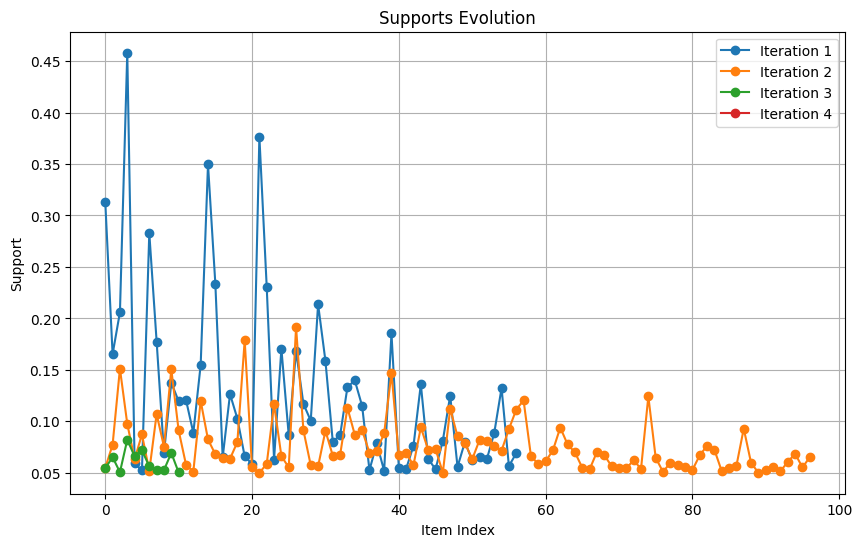

In [32]:
visualize_supports_evolution(item_support_dict1, freq_items1)

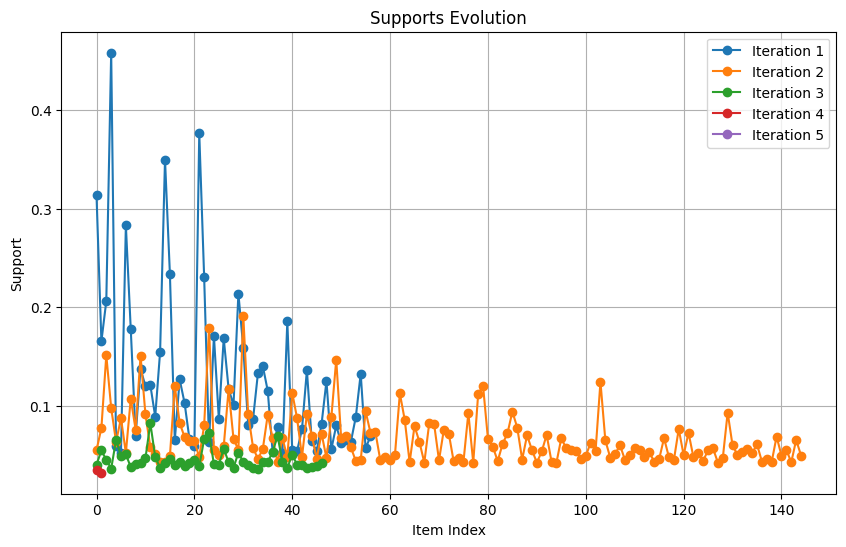

In [33]:
visualize_supports_evolution(item_support_dict2, freq_items2)

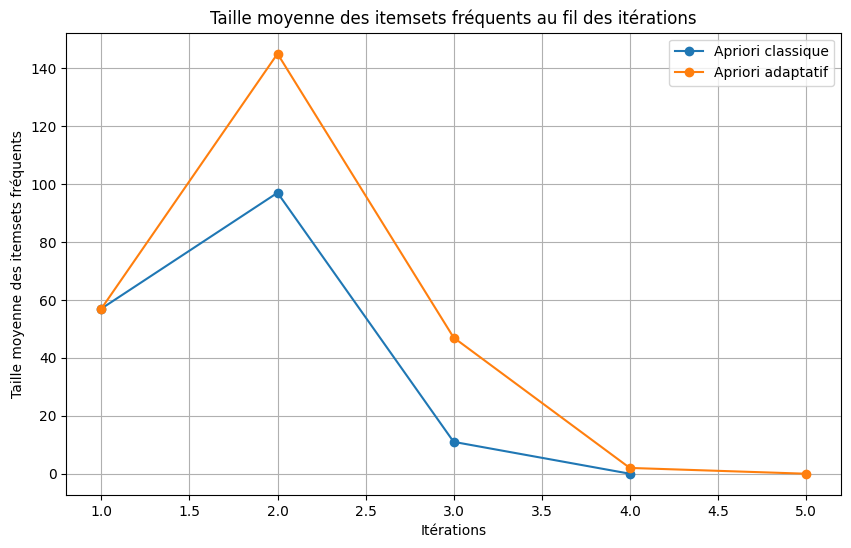

In [34]:
plot_itemset_sizes(freq_items1, freq_items2)

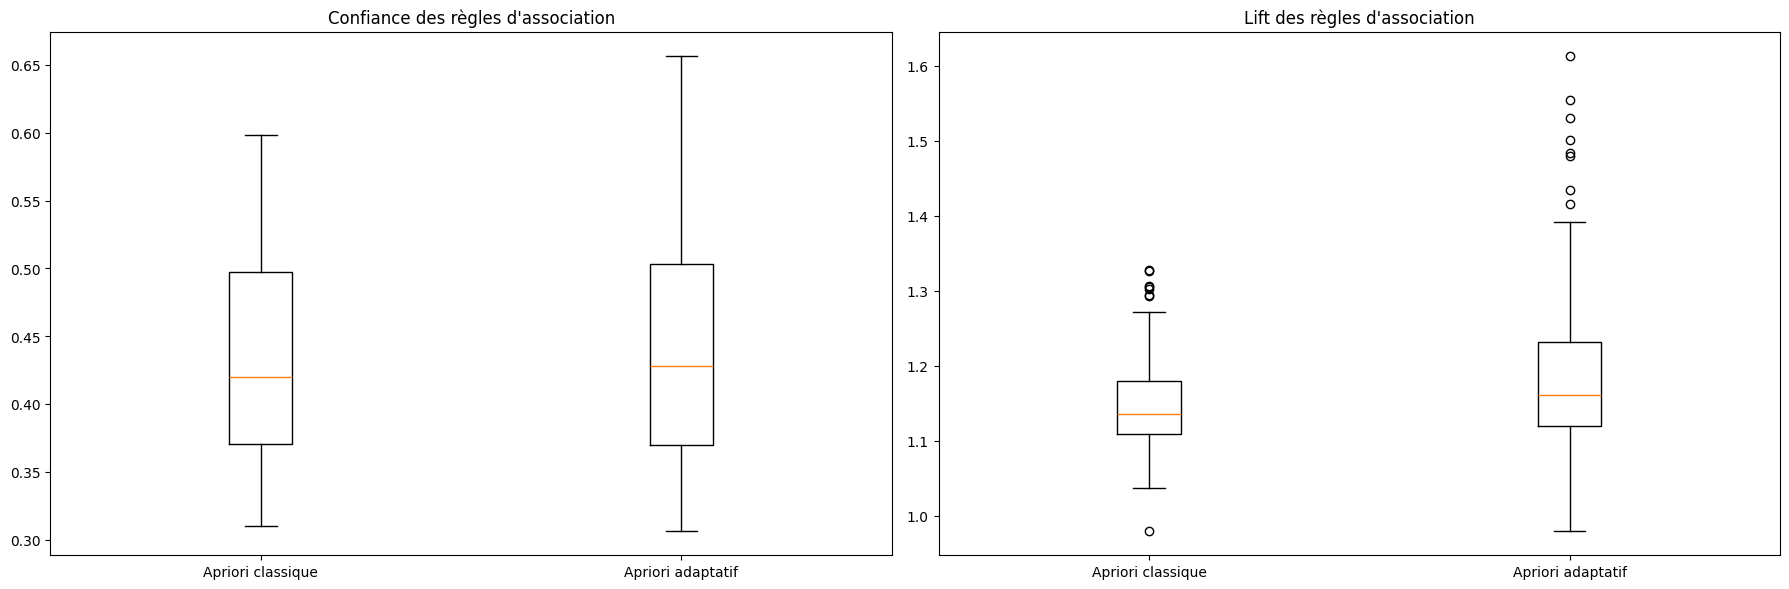

In [35]:
plot_association_rule_quality(as_rules1, as_rules2)

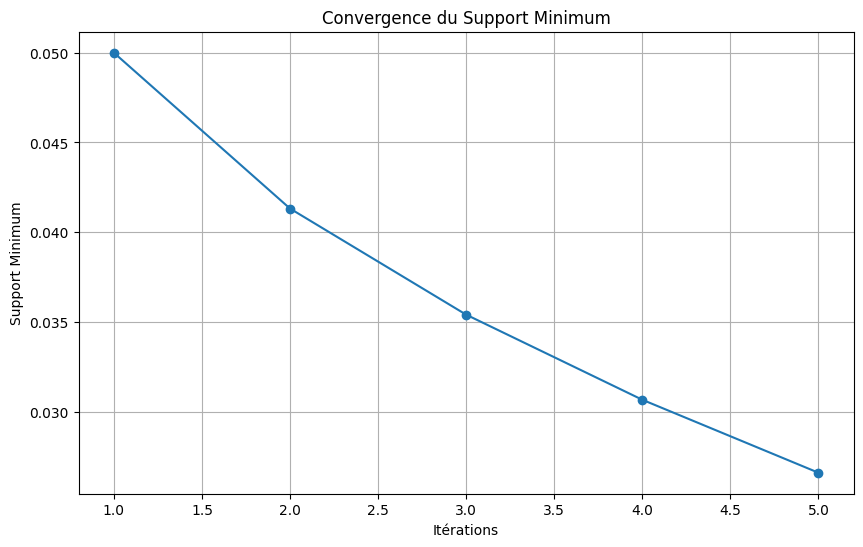

In [36]:
plot_convergence_min_support(minsup_list)

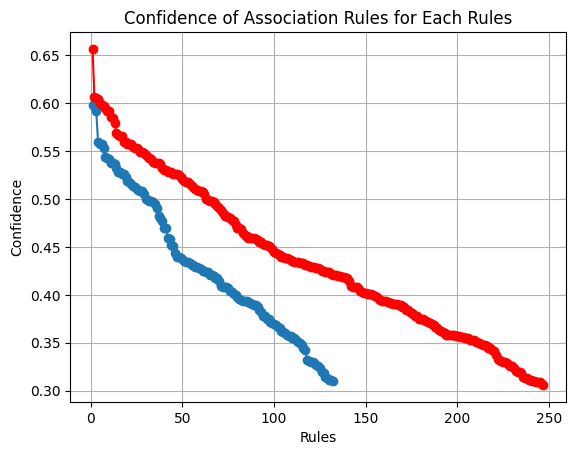

In [37]:
confidence_values1 = [rule[2] for rule in as_rules1]
confidence_values2 = [rule[2] for rule in as_rules2]

# Plotting
plt.plot(range(1, len(confidence_values1) + 1), confidence_values1, marker='o')
plt.plot(range(1, len(confidence_values2) + 1), confidence_values2, marker='o', color='red')
plt.xlabel('Rules')
plt.ylabel('Confidence')
plt.title('Confidence of Association Rules for Each Rules')
plt.grid(True)
plt.show()